In [1]:
suppressWarnings({
    library(lmerTest)
    library(lme4)
    library(ggplot2)
    library(dplyr)
    library(tidyr)
    library(sjPlot)
    library(IRdisplay)
})


Loading required package: lme4
Loading required package: Matrix

Attaching package: ‘lmerTest’

The following object is masked from ‘package:lme4’:

    lmer

The following object is masked from ‘package:stats’:

    step


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘tidyr’

The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack

Learn more about sjPlot with 'browseVignettes("sjPlot")'.


# Investigating MHWs + Phytoplankton Performance Response via LMMs

Tony Cannistra, May 2020

**Purpose**: To experiment with linear mixed effects models to examine whether a significant relationship exists between latitude, sea surface temperature, and performance ratio during marine heatwave events. 

**Method**: Build a linear mixed model of performance ratio with the following effects: 

*Fixed*: 
* latitude + Latitude ^2
* mean_sst_event_year_local

*Random*:
* phytoplankton isolate
* season?

Perhaps season should be a fixed effect, especially since it likely does have control over the direction + shape of the curve. 

## Data

We compute individual isolate performance for all local heatwaves in [this notebook](../Individual_Isolate_performance.ipynb), and use these data below. 

In [2]:
mhwPerformance <- read.csv("../isolate_performance.csv")
mhwPerformance = mhwPerformance %>% mutate(isolate = factor(isolate))
head(mhwPerformance)

X,lat,lon,isolate,mhw,detriment_sum,relative_detriment_mean,detriment_mean,performance_diff_sum,performance_ratio_mean,intensity_cumulative,intensity_mean,duration,start_doy,peak_doy,current_year_sst_mean,perf_det_ratio,latbin,doy_bins
0,-74.875,164.625,1,4,2.632757,1,0.3290947,0,NA,11.680295,1.2978105,9,1,1,-1.202301,1,"(-75.026, -59.75]","(0.639, 91.25]"
1,-74.875,164.625,1,5,4.936420,1,0.3290947,0,NA,24.453109,1.5283193,16,21,32,-1.103370,1,"(-75.026, -59.75]","(0.639, 91.25]"
2,-74.875,164.625,1,11,5.594609,1,0.3290947,0,NA,3.379142,0.1877301,18,232,244,-1.168743,1,"(-75.026, -59.75]","(181.5, 271.75]"
3,-74.875,164.625,1,14,5.923704,1,0.3290947,0,NA,3.307942,0.1741022,19,196,201,-1.181397,1,"(-75.026, -59.75]","(181.5, 271.75]"
4,-74.875,164.625,1,37,3.620041,1,0.3290947,0,NA,1.872364,0.1560303,12,215,220,-1.219370,1,"(-75.026, -59.75]","(181.5, 271.75]"
5,-74.875,164.625,1,69,3.290947,1,0.3290947,0,NA,1.488562,0.1353238,11,133,138,-1.088333,1,"(-75.026, -59.75]","(91.25, 181.5]"


We need to adjust for the effect of hemisphere to "align" seasons and convert to "season" factor variables from "peak_doy" column:

In [3]:
mhwPerformance[between(mhwPerformance$lat, -90, 0), 'peak_doy'] = (mhwPerformance[between(mhwPerformance$lat, -90, 0), 'peak_doy'] - 180) %% 365

In [4]:
mhwPerformance = mhwPerformance %>%  
                    mutate(season = 
                           case_when(
                                (between(peak_doy, 0, 77) | between(peak_doy, 355, 366)) ~ "winter", # January 1 - March XX or December XX - December 31
                                between(peak_doy, 78, 170) ~ "spring", # March XX - June XX
                                between(peak_doy, 171, 295) ~ "summer", # June XX - September XX
                                between(peak_doy, 296, 354) ~ "fall" # September XX - December XX
                        )
                    )

In [5]:
head(mhwPerformance %>% select(peak_doy, season))

peak_doy,season
186,summer
217,summer
64,winter
21,winter
40,winter
323,fall


We'll clean up by dropping NAs and `Inf`s 

In [6]:
mhwPerformance = mhwPerformance %>% filter(!is.na(performance_ratio_mean)) %>% filter(is.finite(performance_ratio_mean))

We'll also **scale the input variables** for later, but the initial models will use the raw values: 

In [7]:
mhwPerformance = mhwPerformance %>%
    mutate(
        lat_scaled = scale(lat),
        sst_scaled = scale(current_year_sst_mean), 
    )

## Models

We'll start with a simple linear model:

In [8]:
simple_lm = lm(performance_ratio_mean ~ poly(lat, 2) + current_year_sst_mean  , data=mhwPerformance)
summary(simple_lm)


Call:
lm(formula = performance_ratio_mean ~ poly(lat, 2) + current_year_sst_mean, 
    data = mhwPerformance)

Residuals:
    Min      1Q  Median      3Q     Max 
 -1.484  -0.284  -0.170  -0.054 219.670 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)            1.443891   0.340966   4.235 2.33e-05 ***
poly(lat, 2)1          4.008360   3.587112   1.117    0.264    
poly(lat, 2)2          1.641856   8.952186   0.183    0.854    
current_year_sst_mean -0.009608   0.017028  -0.564    0.573    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.583 on 4915 degrees of freedom
Multiple R-squared:  0.00093,	Adjusted R-squared:  0.0003202 
F-statistic: 1.525 on 3 and 4915 DF,  p-value: 0.2058


In [9]:
baseline_hline = geom_hline(yintercept=1, linetype='dashed', color='blue', size=0.6, alpha=0.6)

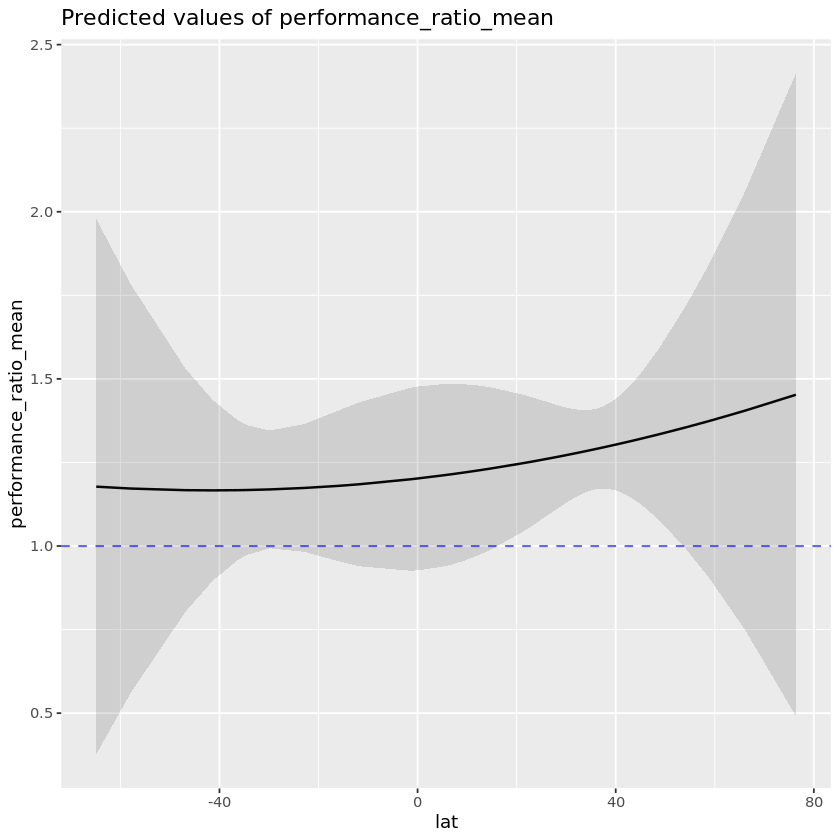

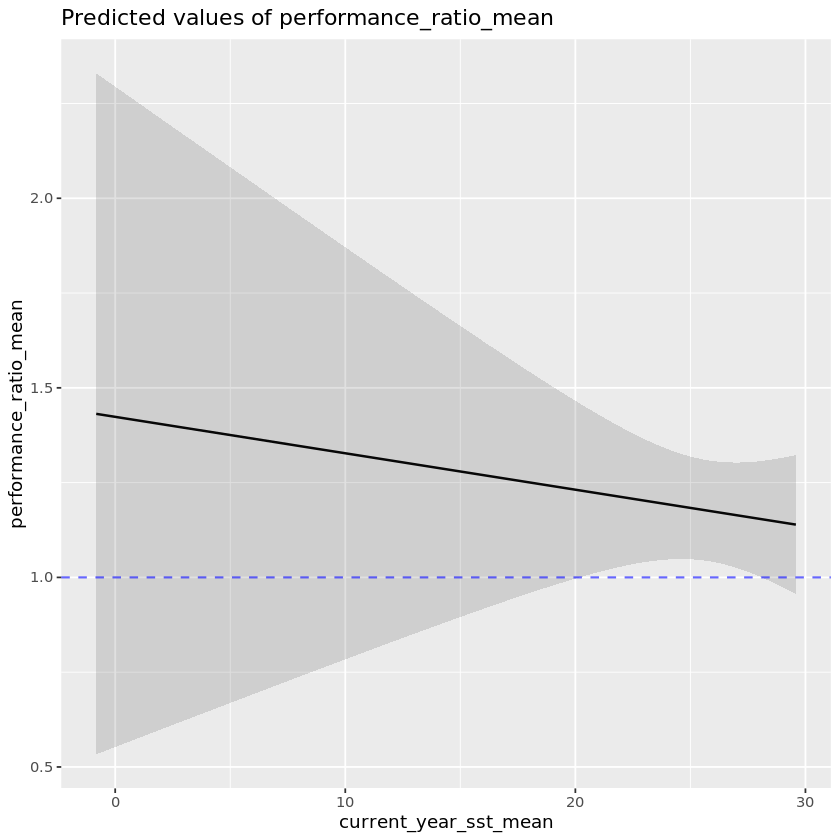

In [10]:
simple_plots = plot_model(simple_lm, type='pred')
simple_plots$lat + baseline_hline
simple_plots$current_year_sst_mean + baseline_hline

## Simple Linear model with Interaction

In [11]:
simple_interact_lm = lm(performance_ratio_mean ~ poly(lat, 2) + current_year_sst_mean + poly(lat, 2)*current_year_sst_mean, data=mhwPerformance)
summary(simple_interact_lm)


Call:
lm(formula = performance_ratio_mean ~ poly(lat, 2) + current_year_sst_mean + 
    poly(lat, 2) * current_year_sst_mean, data = mhwPerformance)

Residuals:
    Min      1Q  Median      3Q     Max 
 -1.431  -0.296  -0.176  -0.021 219.633 

Coefficients:
                                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)                          1.42442    0.35961   3.961 7.57e-05 ***
poly(lat, 2)1                       -0.01825    6.19012  -0.003    0.998    
poly(lat, 2)2                        3.04116    9.05790   0.336    0.737    
current_year_sst_mean               -0.00984    0.01862  -0.528    0.597    
poly(lat, 2)1:current_year_sst_mean  0.37920    0.41956   0.904    0.366    
poly(lat, 2)2:current_year_sst_mean -0.23838    0.44006  -0.542    0.588    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.584 on 4913 degrees of freedom
Multiple R-squared:  0.00115,	Adjusted R-squared:  0.0001332 
F-statistic: 1

**ANOVA**: 

In [12]:
anova(simple_lm, simple_interact_lm)

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
4915,63115.11,NA,NA,NA,NA
4913,63101.23,2,13.88366,0.5404843,0.5825007


## Simple Model with Random Effects

Only `isolate` as random effect for now: 

In [13]:
simple_re = lmer(performance_ratio_mean ~ poly(lat, 2) + current_year_sst_mean  + (1|isolate), data=mhwPerformance)
summary(simple_re)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: performance_ratio_mean ~ poly(lat, 2) + current_year_sst_mean +  
    (1 | isolate)
   Data: mhwPerformance

REML criterion at convergence: 26416.3

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-1.769 -0.043 -0.013  0.010 60.919 

Random effects:
 Groups   Name        Variance Std.Dev.
 isolate  (Intercept)  1.106   1.052   
 Residual             12.251   3.500   
Number of obs: 4919, groups:  isolate, 73

Fixed effects:
                      Estimate Std. Error       df t value Pr(>|t|)
(Intercept)            1.04720    0.82569 70.34997   1.268    0.209
poly(lat, 2)1          5.02764    9.57839 49.29113   0.525    0.602
poly(lat, 2)2          8.76794   22.38246 65.44724   0.392    0.697
current_year_sst_mean  0.01472    0.04143 70.73972   0.355    0.723

Correlation of Fixed Effects:
            (Intr) p(,2)1 p(,2)2
poly(lt,2)1  0.005              
poly(lt,2)2 -0.890 -0.012       


Model contains splines or polynomial terms. Consider using `terms="lat [all]"` to get smooth plots. See also package-vignette 'Marginal Effects at Specific Values'.
Model contains splines or polynomial terms. Consider using `terms="current_year_sst_mean [all]"` to get smooth plots. See also package-vignette 'Marginal Effects at Specific Values'.


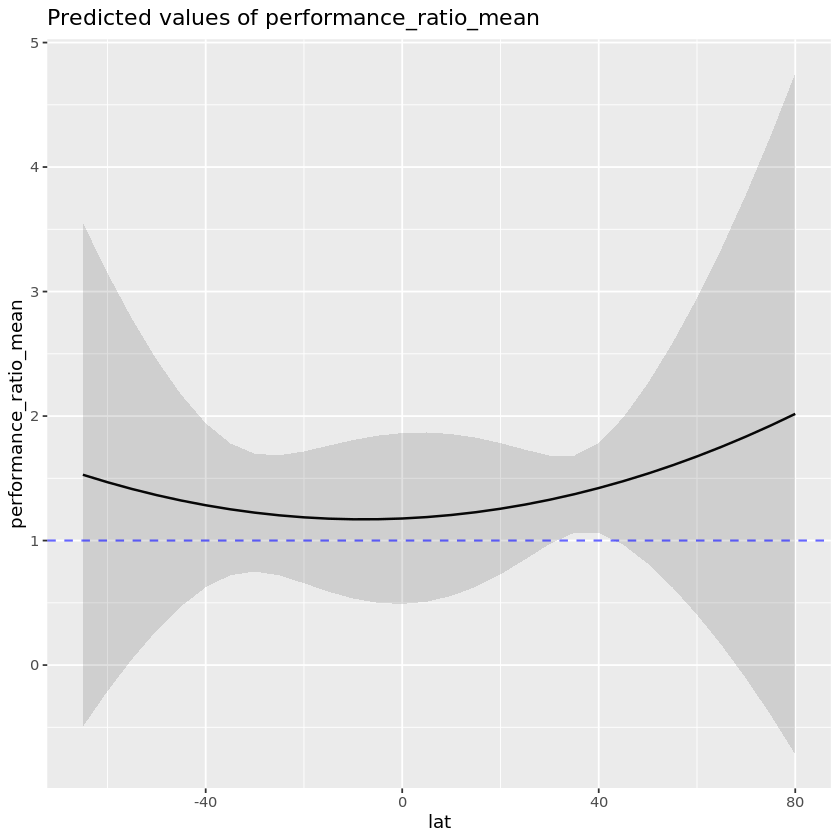

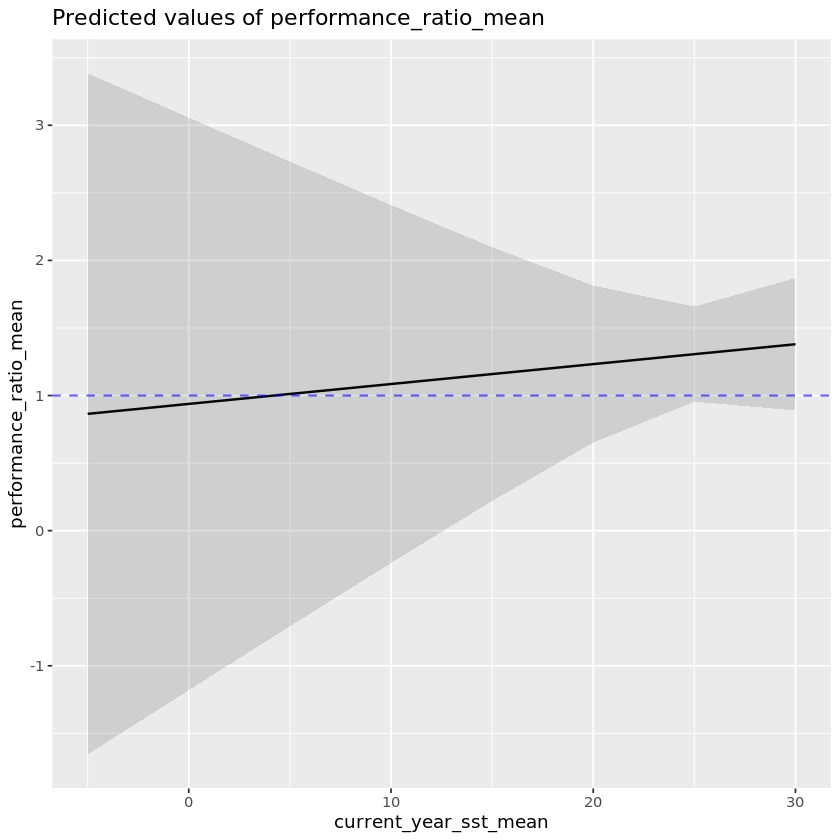

In [14]:
simple_re_plots = plot_model(simple_re, type='pred')
simple_re_plots$lat + baseline_hline
simple_re_plots$current_year_sst_mean + baseline_hline

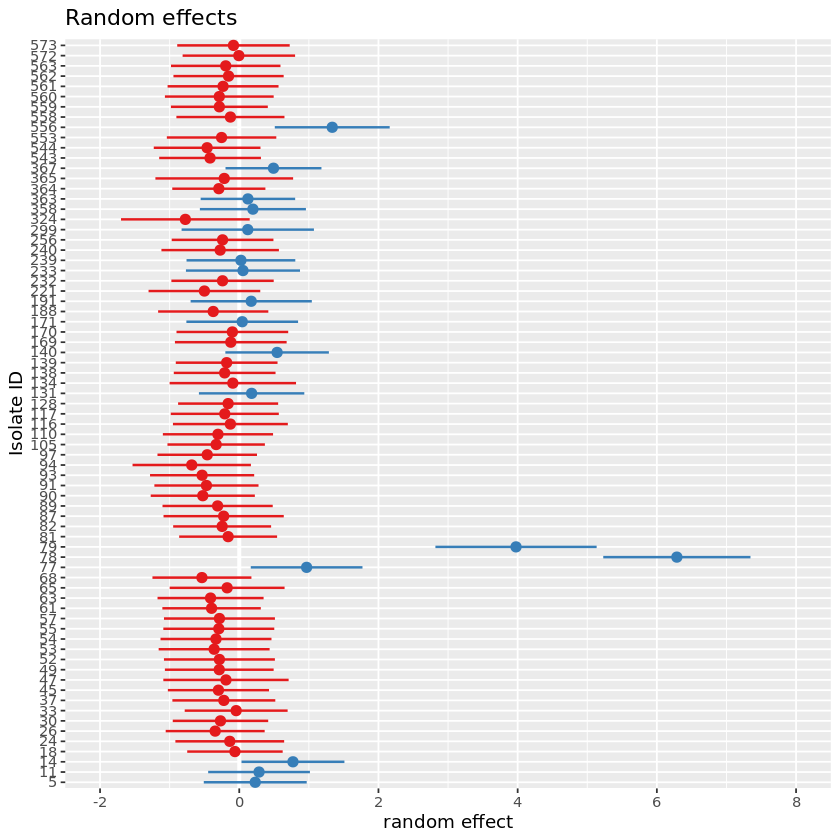

In [15]:
plot_model(simple_re, type='re') + xlab("Isolate ID") + ylab('random effect')

##  Model with Random Effects + Interaction

In [24]:
interact_re = lmer(performance_ratio_mean ~ poly(lat, 2) + current_year_sst_mean + poly(lat,2)*current_year_sst_mean + (1|isolate), data=mhwPerformance)
summary(interact_re)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: performance_ratio_mean ~ poly(lat, 2) + current_year_sst_mean +  
    poly(lat, 2) * current_year_sst_mean + (1 | isolate)
   Data: mhwPerformance

REML criterion at convergence: 26411.2

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-1.791 -0.044 -0.012  0.012 60.901 

Random effects:
 Groups   Name        Variance Std.Dev.
 isolate  (Intercept)  1.147   1.071   
 Residual             12.249   3.500   
Number of obs: 4919, groups:  isolate, 73

Fixed effects:
                                    Estimate Std. Error       df t value
(Intercept)                          0.97683    0.86537 74.94985   1.129
poly(lat, 2)1                       -6.01953   17.00057 50.07582  -0.354
poly(lat, 2)2                       10.96401   23.17110 61.75202   0.473
current_year_sst_mean                0.01644    0.04505 75.66395   0.365
poly(lat, 2)1:current_year_sst_mean  0.99620    1.15006 50.46111  

Model contains splines or polynomial terms. Consider using `terms="lat [all]"` to get smooth plots. See also package-vignette 'Marginal Effects at Specific Values'.
Model contains splines or polynomial terms. Consider using `terms="current_year_sst_mean [all]"` to get smooth plots. See also package-vignette 'Marginal Effects at Specific Values'.


$lat

$current_year_sst_mean


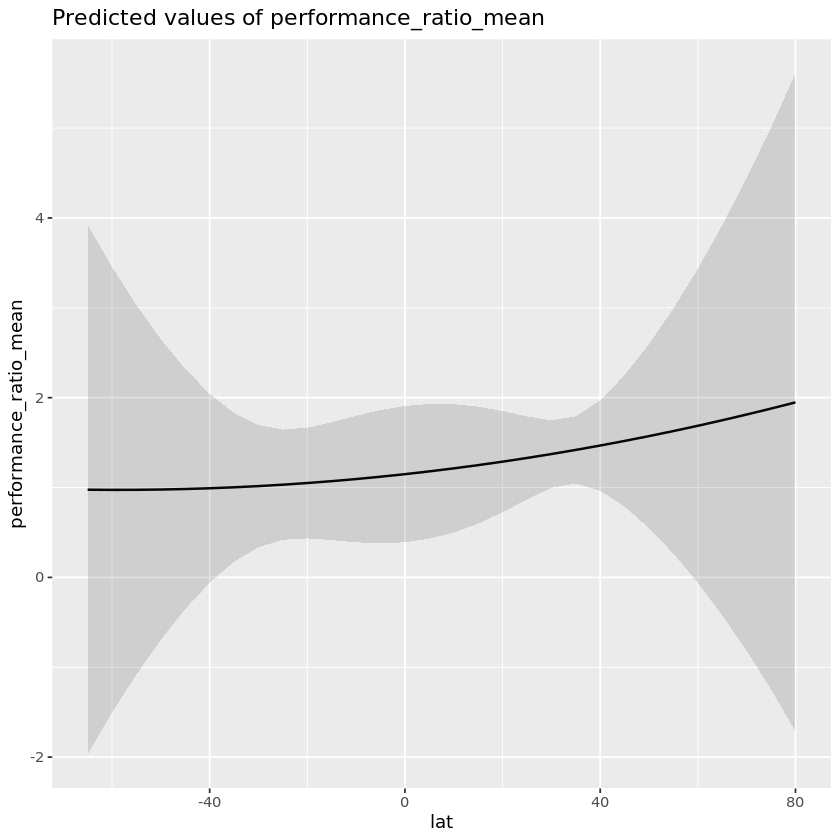

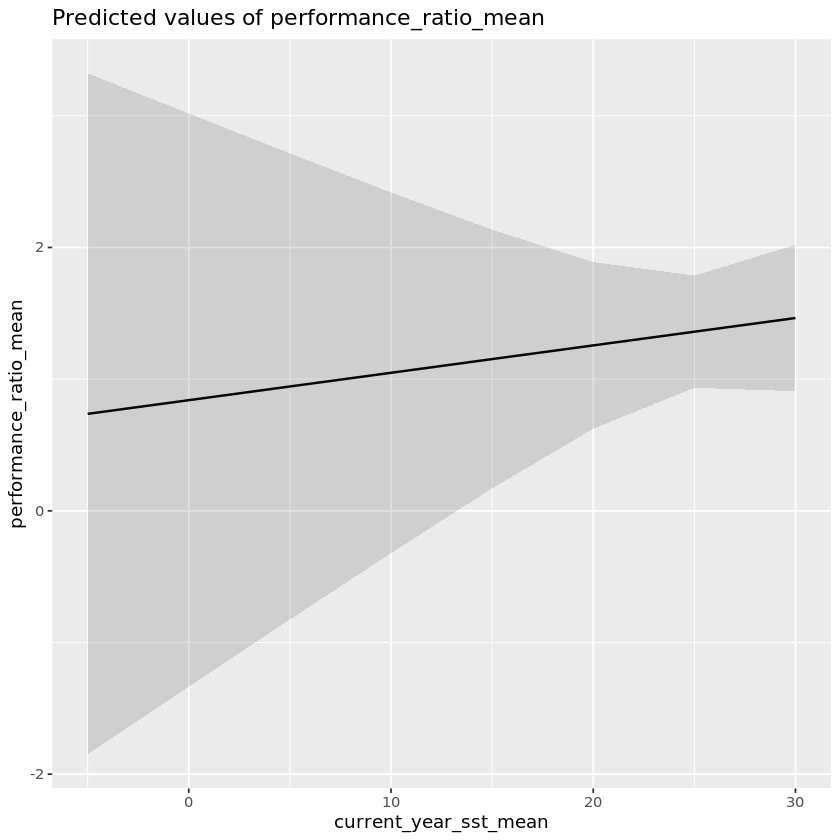

In [25]:
plot_model(interact_re, type='pred')

## Is `season` a random or fixed effect?

Warning message:
“Removed 95 rows containing non-finite values (stat_boxplot).”

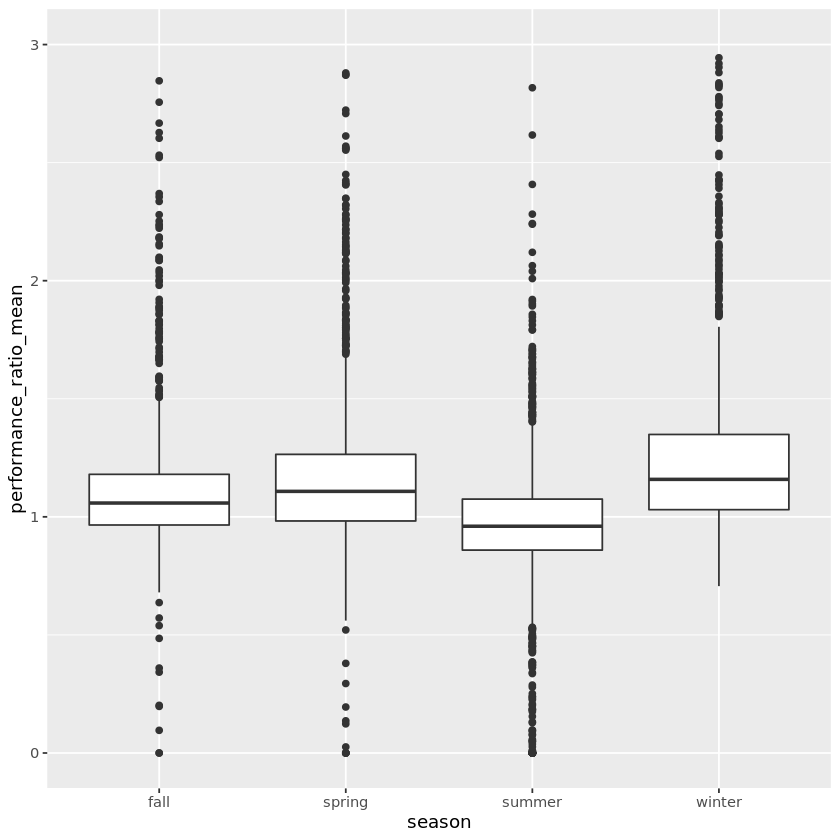

In [26]:
ggplot(mhwPerformance, aes(x = season, y = performance_ratio_mean)) + geom_boxplot() + ylim(0, 3)

Intuitively, since it's likely that season has a significant (mechanistic?) effect on performance impacts, it should probably be a fixed parameter?

### Season as Fixed Effect

**Simple LM**:

In [65]:
season_lm = lm(performance_ratio_mean ~ poly(lat, 2) + current_year_sst_mean + season-1 , data=mhwPerformance)
summary(season_lm)


Call:
lm(formula = performance_ratio_mean ~ poly(lat, 2) + current_year_sst_mean + 
    season - 1, data = mhwPerformance)

Residuals:
    Min      1Q  Median      3Q     Max 
 -1.788  -0.388  -0.122   0.058 219.367 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
poly(lat, 2)1          4.37562    3.57955   1.222 0.221618    
poly(lat, 2)2          0.16701    8.94564   0.019 0.985106    
current_year_sst_mean -0.01234    0.01702  -0.725 0.468241    
seasonfall             1.40108    0.36621   3.826 0.000132 ***
seasonspring           1.80079    0.35106   5.129 3.02e-07 ***
seasonsummer           1.20358    0.34356   3.503 0.000464 ***
seasonwinter           1.74933    0.35838   4.881 1.09e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.575 on 4912 degrees of freedom
Multiple R-squared:  0.1148,	Adjusted R-squared:  0.1136 
F-statistic: 91.03 on 7 and 4912 DF,  p-value: < 2.2e-16


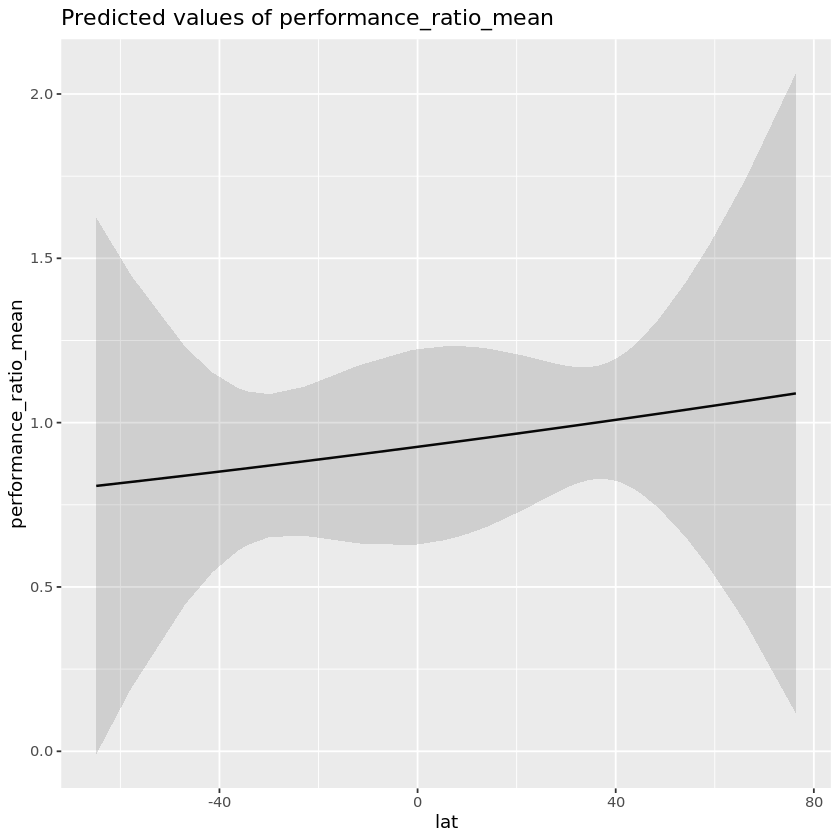

$lat

$current_year_sst_mean

$season


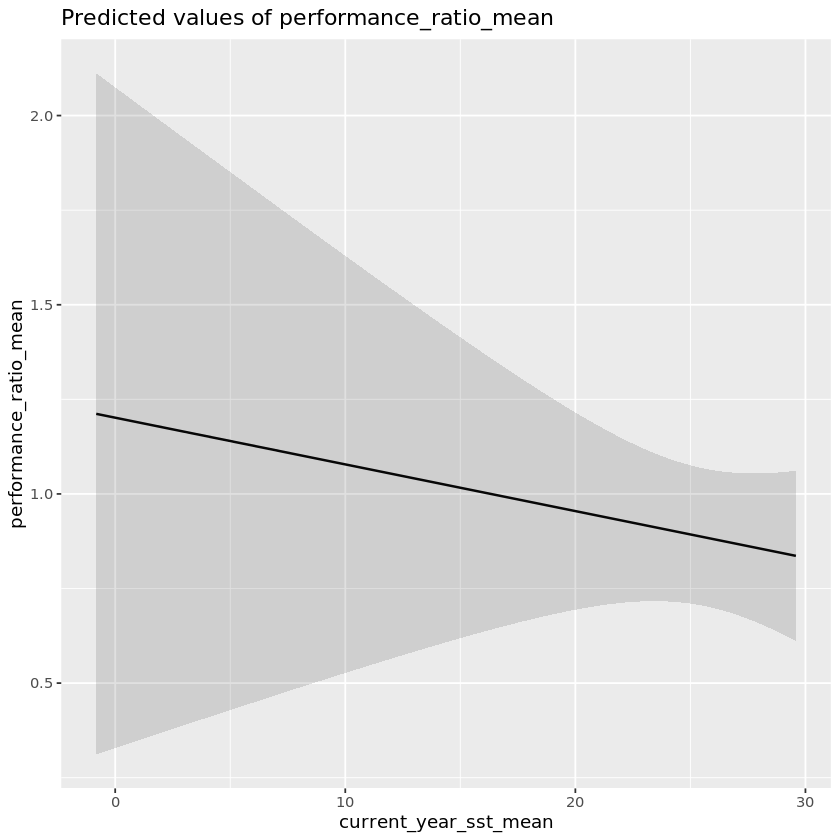

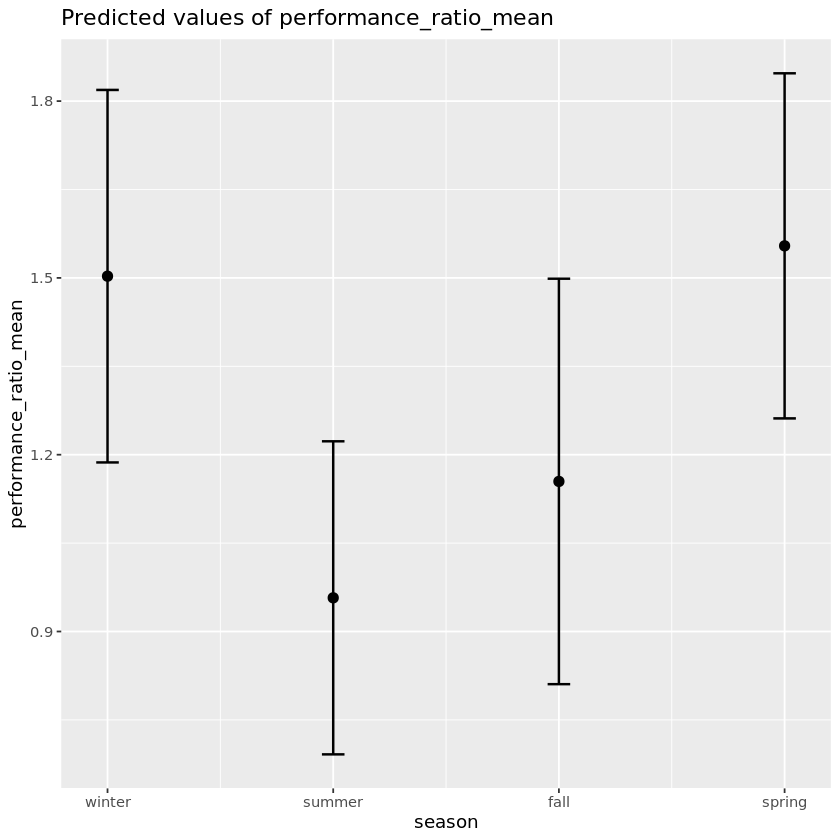

In [66]:
plot_model(season_lm, type='pred')

**Random Effects model with Season**

In [68]:
season_re = lmer(performance_ratio_mean ~ poly(lat,2) + current_year_sst_mean + poly(lat,2)*current_year_sst_mean + season-1  +  (1 | isolate), data=mhwPerformance)
summary(season_re)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: performance_ratio_mean ~ poly(lat, 2) + current_year_sst_mean +  
    poly(lat, 2) * current_year_sst_mean + season - 1 + (1 |      isolate)
   Data: mhwPerformance

REML criterion at convergence: 26380.3

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-1.768 -0.088 -0.015  0.054 60.987 

Random effects:
 Groups   Name        Variance Std.Dev.
 isolate  (Intercept)  1.228   1.108   
 Residual             12.152   3.486   
Number of obs: 4919, groups:  isolate, 73

Fixed effects:
                                    Estimate Std. Error       df t value
poly(lat, 2)1                       -5.98875   17.49426 51.17217  -0.342
poly(lat, 2)2                        6.19252   23.78501 63.67286   0.260
current_year_sst_mean                0.00793    0.04610 78.83987   0.172
seasonfall                           1.00384    0.89473 81.38607   1.122
seasonspring                         1.47188    

Model contains splines or polynomial terms. Consider using `terms="lat [all]"` to get smooth plots. See also package-vignette 'Marginal Effects at Specific Values'.


Error: Confidence intervals could not be computed.
* Reason: "`season` does not have enough factor levels. Try to remove `[]`."
* Source: .safe_se_from_vcov(model, prediction_data, value_adjustment, terms, model_class, type, vcov.fun, vcov.type, vcov.args, condition, interval)


Model contains splines or polynomial terms. Consider using `terms="current_year_sst_mean [all]"` to get smooth plots. See also package-vignette 'Marginal Effects at Specific Values'.


Error: Confidence intervals could not be computed.
* Reason: "`season` does not have enough factor levels. Try to remove `[]`."
* Source: .safe_se_from_vcov(model, prediction_data, value_adjustment, terms, model_class, type, vcov.fun, vcov.type, vcov.args, condition, interval)


Model contains splines or polynomial terms. Consider using `terms="season [all]"` to get smooth plots. See also package-vignette 'Marginal Effects at Specific Values'.


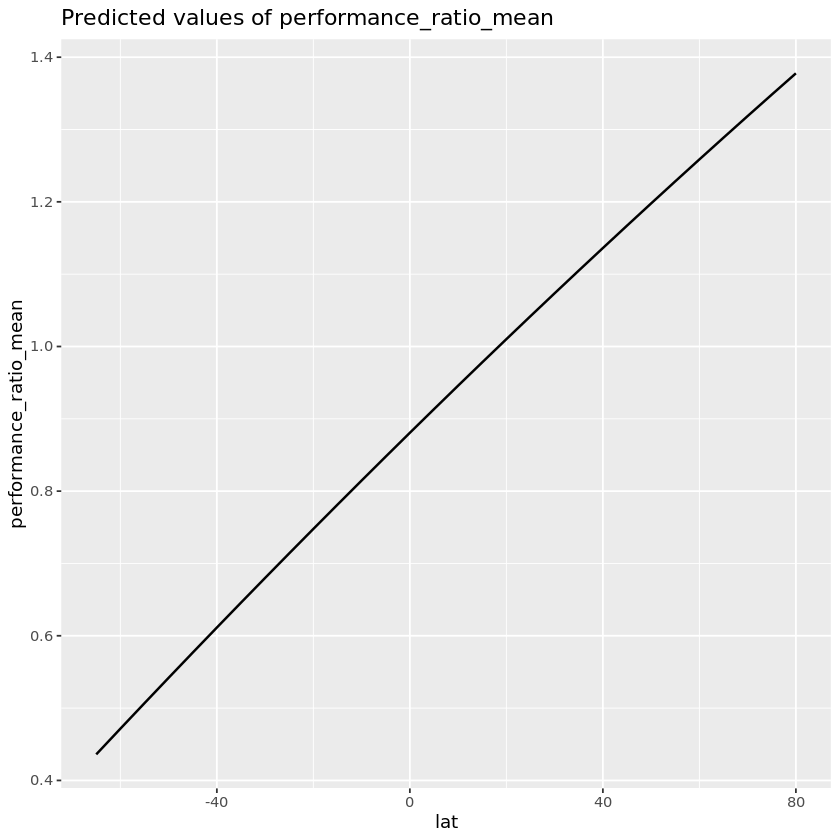

$lat

$current_year_sst_mean

$season


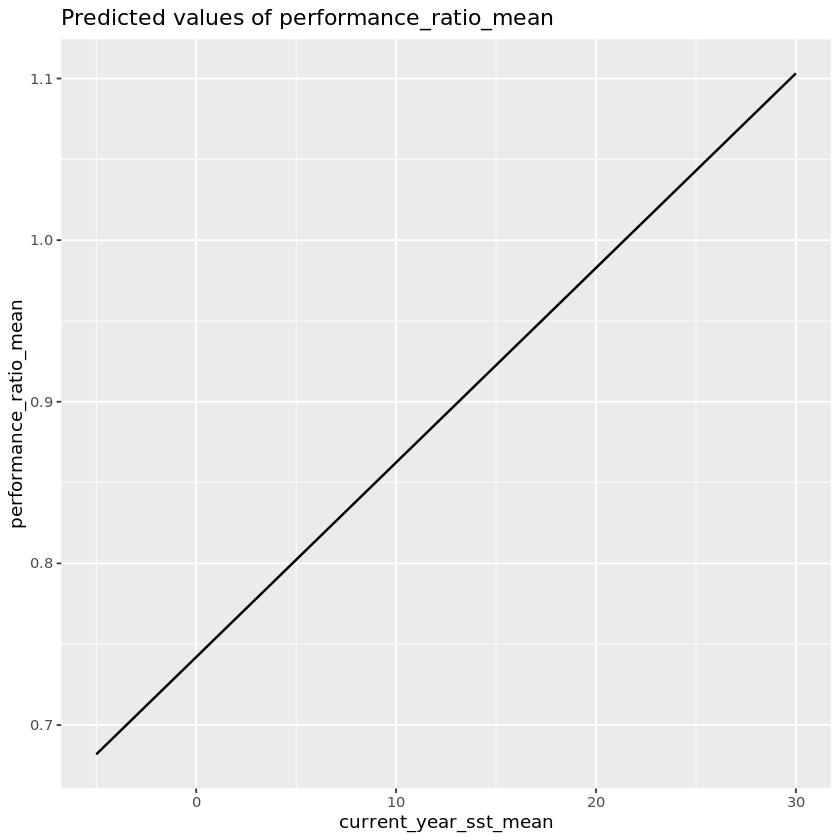

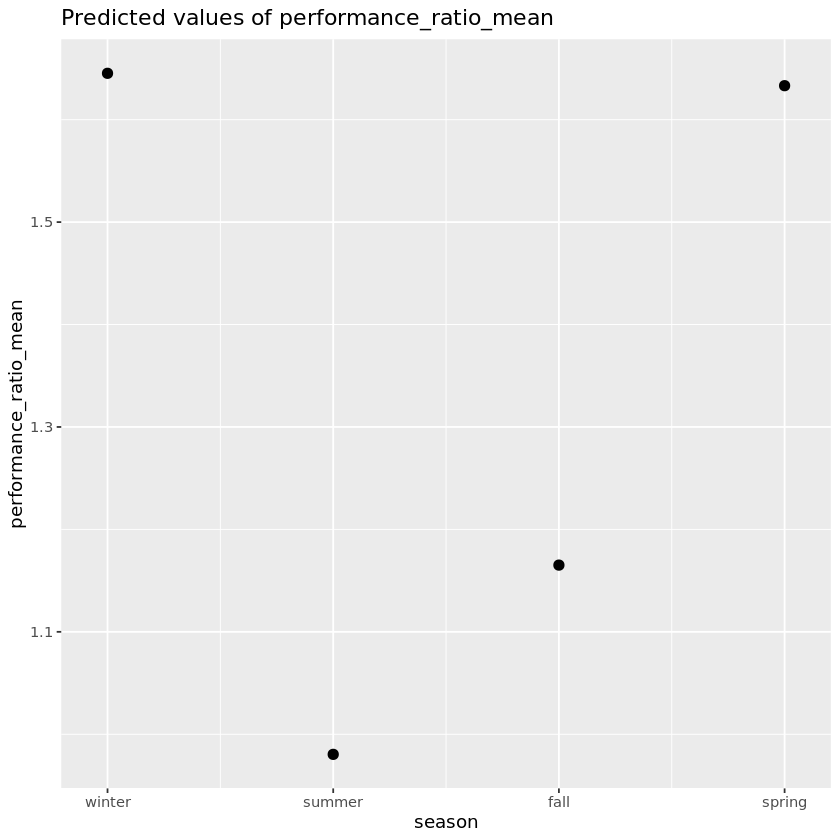

In [69]:
plot_model(season_re, type='pred')

## More Intense Heatwaves =? Stronger Signal?

There's probably a lot of noise from shorter events here. 

Lets take a look at the distribution of heatwaves by intensity: 

In [70]:
median(mhwPerformance$intensity_mean)

[1] 1.541905

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


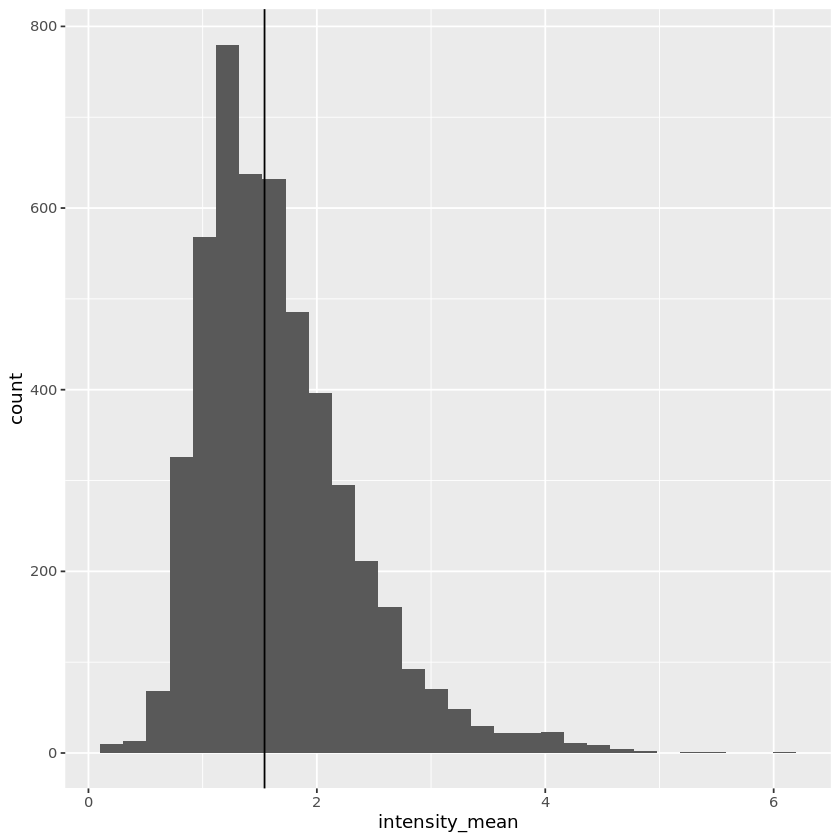

In [71]:
ggplot(mhwPerformance, aes(x=intensity_mean) ) + geom_histogram() + geom_vline(xintercept=median(mhwPerformance$intensity_mean)) 

We can use ~1.5 C as our threshold (median?)

In [72]:
intensity_threshold = 1.5

In [73]:
intenseMhwPerformance = mhwPerformance %>% filter(intensity_mean > intensity_threshold)

In [74]:
head(intenseMhwPerformance)

X,lat,lon,isolate,mhw,detriment_sum,relative_detriment_mean,detriment_mean,performance_diff_sum,performance_ratio_mean,...,duration,start_doy,peak_doy,current_year_sst_mean,perf_det_ratio,latbin,doy_bins,season,lat_scaled,sst_scaled
19,-57.875,139.875,558,6,0.8048469,0.14412670,0.04734394,-0.7973536,0.8569843,...,18,3,190,2.37748,3.234330e+04,"(-59.75, -44.625]","(0.639, 91.25]",summer,-2.322601,-2.3233394
27,-41.375,174.875,18,30,1.2221654,0.09605062,0.02909918,0.9946192,1.0947682,...,43,39,262,14.94652,5.517525e-01,"(-44.625, -29.5]","(0.639, 91.25]",summer,-1.799260,-0.6469757
34,-36.125,174.875,573,53,1.7526555,0.07958929,0.04736907,3.0075834,1.1757085,...,38,1,165,17.80997,3.521463e-01,"(-44.625, -29.5]","(0.639, 91.25]",spring,-1.632742,-0.2650704
37,-34.375,17.125,26,42,0.2014159,0.08242058,0.03356932,-0.1750949,0.9275738,...,7,196,18,18.40364,7.700049e+00,"(-44.625, -29.5]","(181.5, 271.75]",winter,-1.577236,-0.1858907
38,-34.375,17.125,26,45,4.8919199,0.48043255,0.19567680,-2.2139308,0.7046092,...,26,60,263,19.01186,1.827904e+00,"(-44.625, -29.5]","(0.639, 91.25]",summer,-1.577236,-0.1047713
39,-34.375,17.125,26,52,0.9720365,0.10376427,0.04226246,-0.8349681,0.9094785,...,24,179,5,18.62331,7.073921e+00,"(-44.625, -29.5]","(91.25, 181.5]",winter,-1.577236,-0.1565929


In [75]:
nrow(intenseMhwPerformance)

[1] 2597

**Simple Model**

In [117]:
simple_intense_lm = lm(performance_ratio_mean ~ poly(lat,2) + current_year_sst_mean + poly(lat,2)*current_year_sst_mean + season, data=intenseMhwPerformance)
summary(simple_intense_lm)


Call:
lm(formula = performance_ratio_mean ~ poly(lat, 2) + current_year_sst_mean + 
    poly(lat, 2) * current_year_sst_mean + season, data = intenseMhwPerformance)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.4955 -0.2511 -0.0709  0.0833 25.0065 

Coefficients:
                                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)                          1.694928   0.121115  13.994  < 2e-16 ***
poly(lat, 2)1                       -4.443777   2.607799  -1.704   0.0885 .  
poly(lat, 2)2                       -2.451566   1.811807  -1.353   0.1761    
current_year_sst_mean               -0.027134   0.005957  -4.555 5.48e-06 ***
seasonspring                         0.163277   0.062823   2.599   0.0094 ** 
seasonsummer                        -0.249552   0.058897  -4.237 2.34e-05 ***
seasonwinter                         0.474010   0.069582   6.812 1.19e-11 ***
poly(lat, 2)1:current_year_sst_mean  0.351744   0.151037   2.329   0.0199 *  
poly(lat, 2)2:current_y

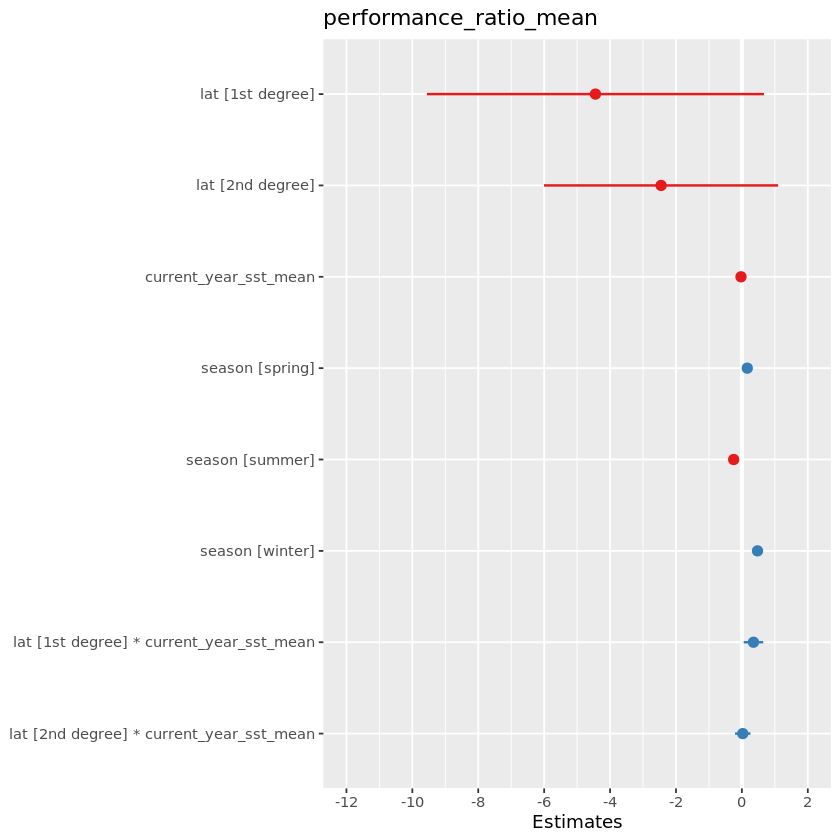

In [118]:
plot_model(simple_intense_lm)

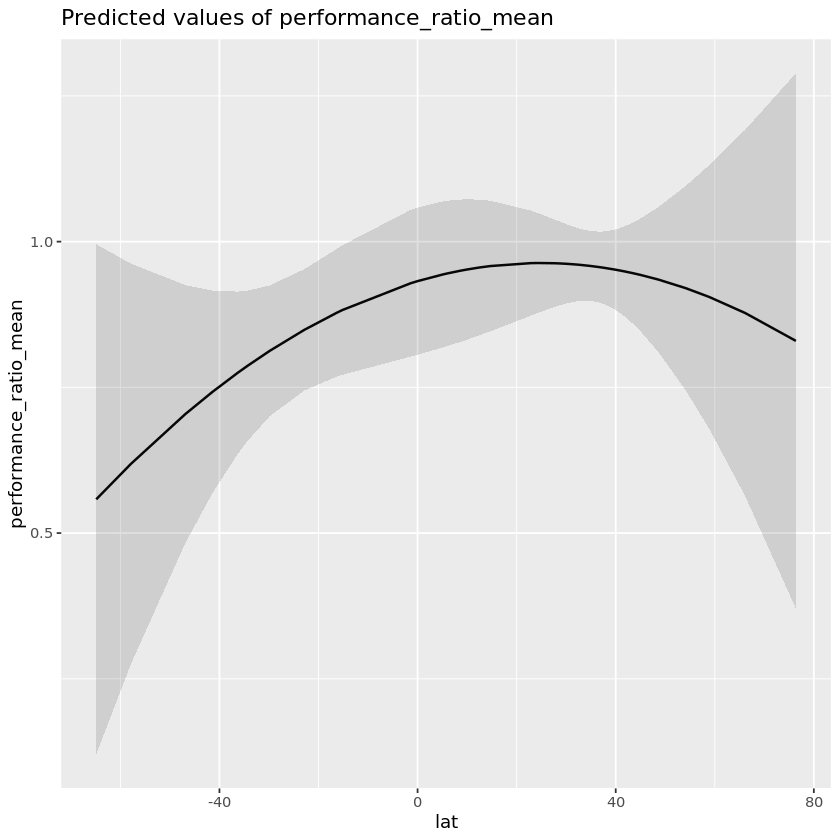

$lat

$current_year_sst_mean

$season


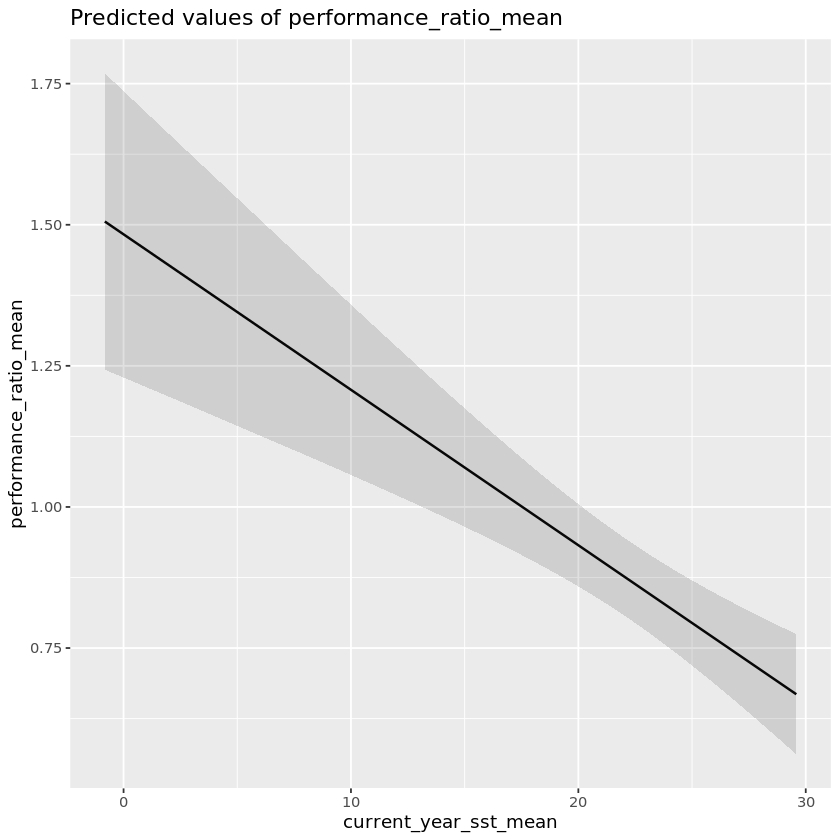

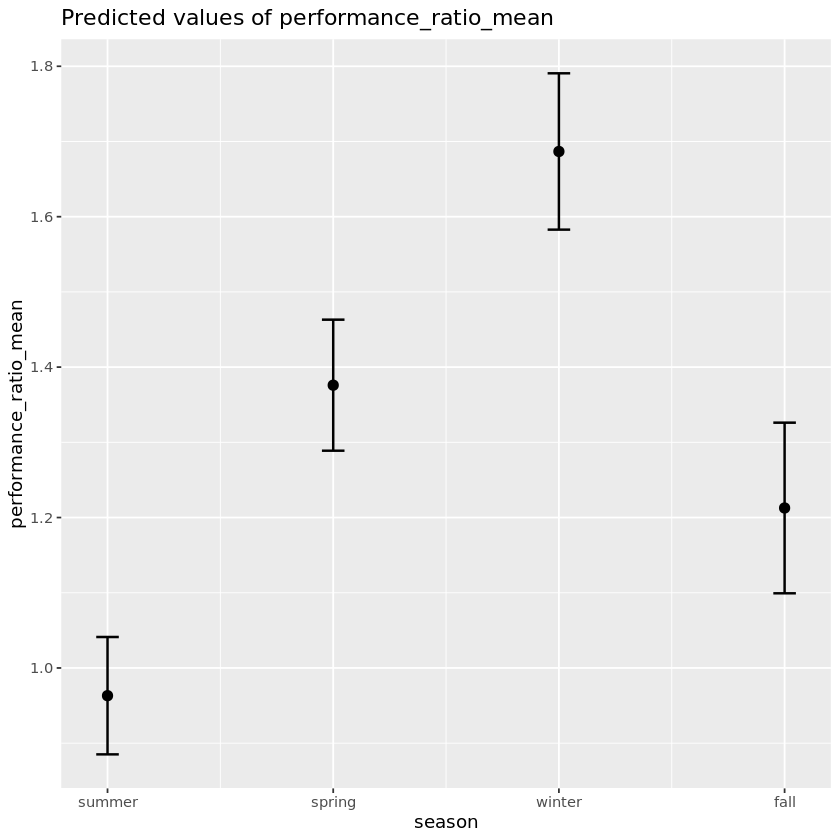

In [119]:
plot_model(simple_intense_lm, type='pred')

**Simple Random Effects**

In [120]:
simple_intense_re = lmer(performance_ratio_mean ~ poly(lat,2) + current_year_sst_mean  + season + (1 | isolate), data=intenseMhwPerformance, )

In [121]:
summary(simple_intense_re)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: performance_ratio_mean ~ poly(lat, 2) + current_year_sst_mean +  
    season + (1 | isolate)
   Data: intenseMhwPerformance

REML criterion at convergence: 6754.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.4506 -0.2409 -0.0247  0.1673 27.8409 

Random effects:
 Groups   Name        Variance Std.Dev.
 isolate  (Intercept) 0.1372   0.3704  
 Residual             0.7496   0.8658  
Number of obs: 2597, groups:  isolate, 66

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)              1.58419    0.28357  100.89562   5.587 1.97e-07 ***
poly(lat, 2)1            0.49855    2.43487   79.76800   0.205  0.83828    
poly(lat, 2)2            0.35060    3.74232   90.23257   0.094  0.92557    
current_year_sst_mean   -0.02198    0.01430  101.21067  -1.537  0.12752    
seasonspring             0.17140    0.05867 2580.91605   2.921  0

Model contains splines or polynomial terms. Consider using `terms="lat [all]"` to get smooth plots. See also package-vignette 'Marginal Effects at Specific Values'.


Error: Confidence intervals could not be computed.
* Reason: "`season` does not have enough factor levels. Try to remove `[]`."
* Source: .safe_se_from_vcov(model, prediction_data, value_adjustment, terms, model_class, type, vcov.fun, vcov.type, vcov.args, condition, interval)


Model contains splines or polynomial terms. Consider using `terms="current_year_sst_mean [all]"` to get smooth plots. See also package-vignette 'Marginal Effects at Specific Values'.


Error: Confidence intervals could not be computed.
* Reason: "`season` does not have enough factor levels. Try to remove `[]`."
* Source: .safe_se_from_vcov(model, prediction_data, value_adjustment, terms, model_class, type, vcov.fun, vcov.type, vcov.args, condition, interval)


Model contains splines or polynomial terms. Consider using `terms="season [all]"` to get smooth plots. See also package-vignette 'Marginal Effects at Specific Values'.


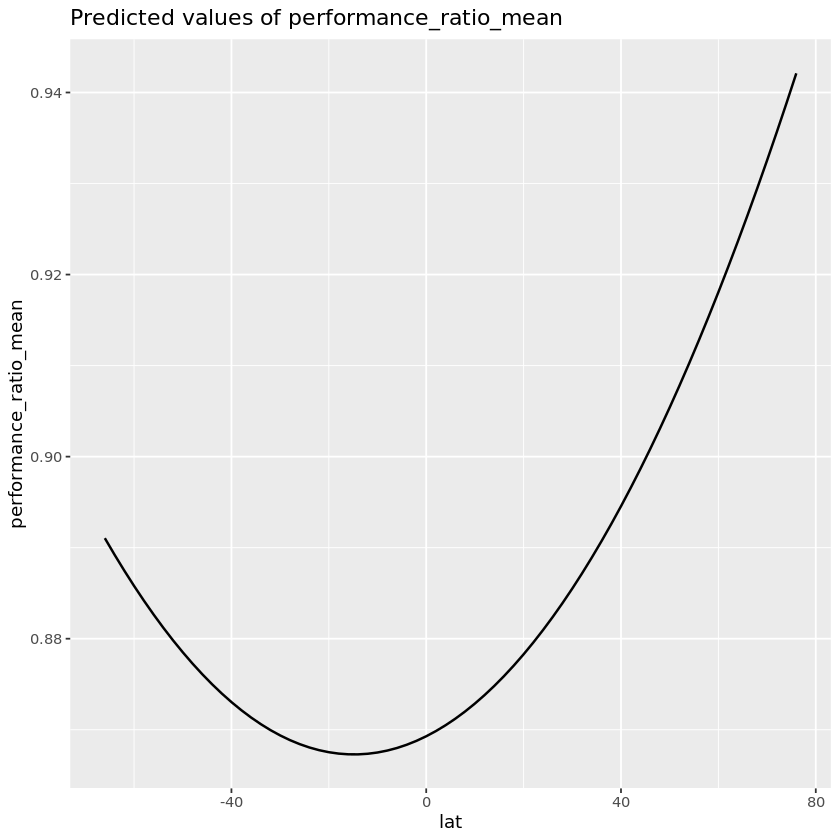

$lat

$current_year_sst_mean

$season


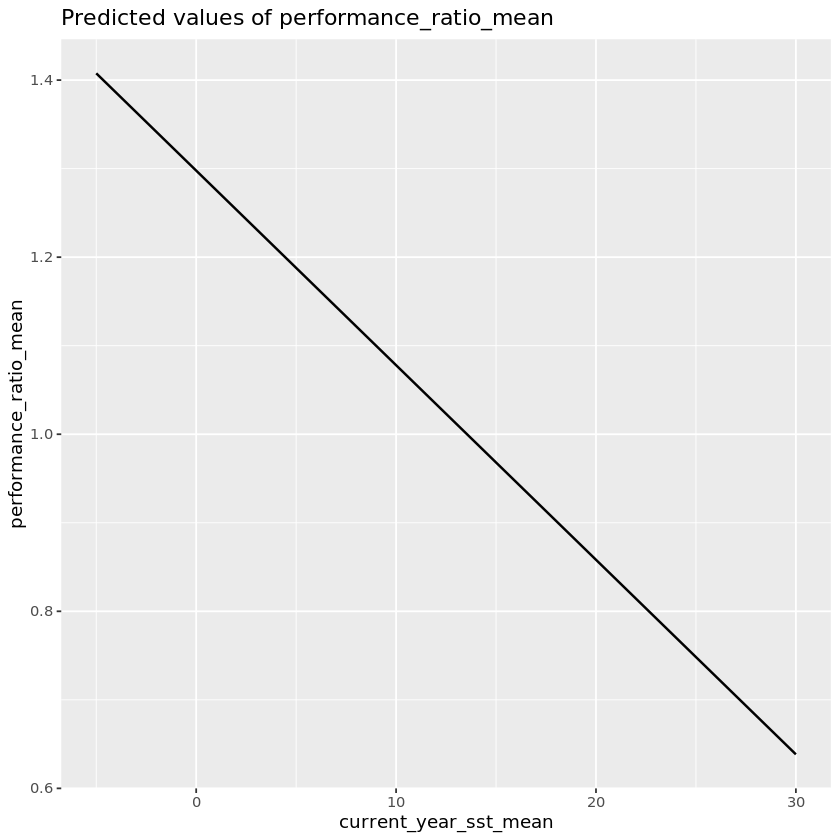

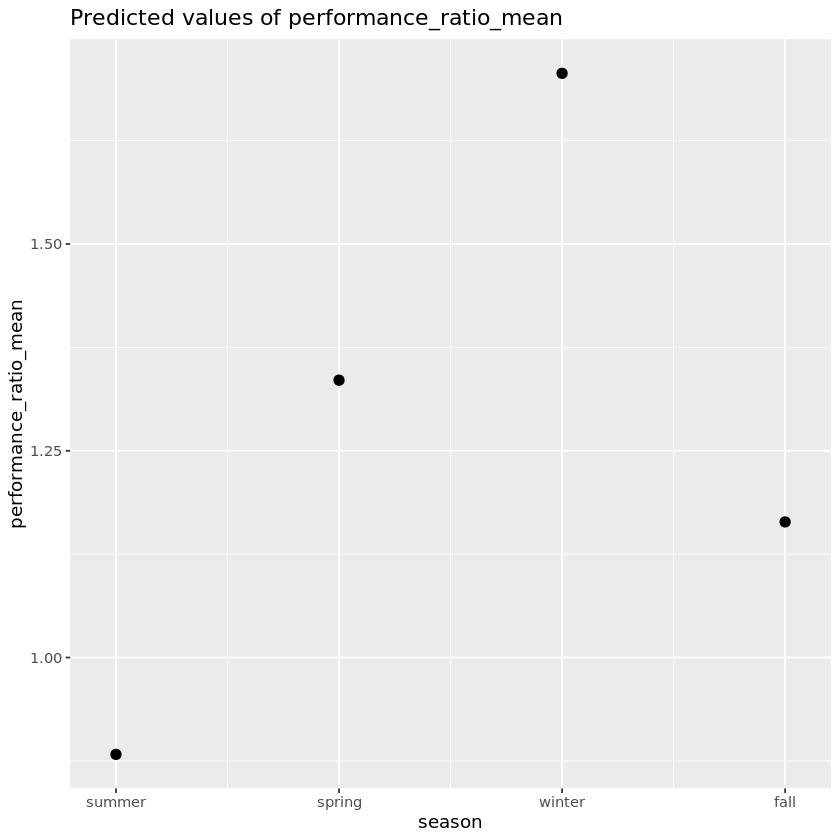

In [123]:
plot_model(simple_intense_re, type='pred')

### Random effects with interaction

In [124]:
simple_intense_re = lmer(performance_ratio_mean ~ poly(lat,2) + current_year_sst_mean + poly(lat,2)*current_year_sst_mean + season + poly(lat,2)*season + (1 | isolate), data=intenseMhwPerformance, )

In [125]:
summary(simple_intense_re)


Correlation matrix not shown by default, as p = 15 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: performance_ratio_mean ~ poly(lat, 2) + current_year_sst_mean +  
    poly(lat, 2) * current_year_sst_mean + season + poly(lat,  
    2) * season + (1 | isolate)
   Data: intenseMhwPerformance

REML criterion at convergence: 6706.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.4565 -0.2294 -0.0187  0.1688 27.8942 

Random effects:
 Groups   Name        Variance Std.Dev.
 isolate  (Intercept) 0.1412   0.3758  
 Residual             0.7437   0.8624  
Number of obs: 2597, groups:  isolate, 66

Fixed effects:
                                      Estimate Std. Error         df t value
(Intercept)                            1.52205    0.29444  103.46336   5.169
poly(lat, 2)1                          0.57212    5.16170  183.88073   0.111
poly(lat, 2)2                         -0.24785    4.83098  177.42001  -0.051
current_year_sst_mean                 -0.01762    0.01542  104.07347

Model contains splines or polynomial terms. Consider using `terms="lat [all]"` to get smooth plots. See also package-vignette 'Marginal Effects at Specific Values'.


Error: Confidence intervals could not be computed.
* Reason: "`season` does not have enough factor levels. Try to remove `[]`."
* Source: .safe_se_from_vcov(model, prediction_data, value_adjustment, terms, model_class, type, vcov.fun, vcov.type, vcov.args, condition, interval)


Model contains splines or polynomial terms. Consider using `terms="current_year_sst_mean [all]"` to get smooth plots. See also package-vignette 'Marginal Effects at Specific Values'.


Error: Confidence intervals could not be computed.
* Reason: "`season` does not have enough factor levels. Try to remove `[]`."
* Source: .safe_se_from_vcov(model, prediction_data, value_adjustment, terms, model_class, type, vcov.fun, vcov.type, vcov.args, condition, interval)


Model contains splines or polynomial terms. Consider using `terms="season [all]"` to get smooth plots. See also package-vignette 'Marginal Effects at Specific Values'.


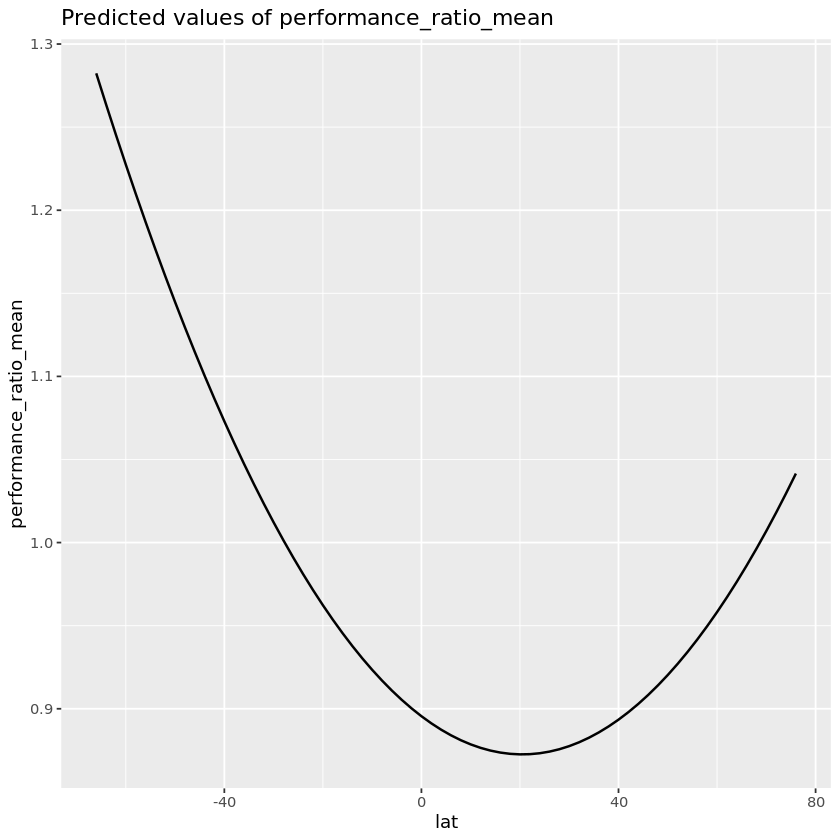

$lat

$current_year_sst_mean

$season


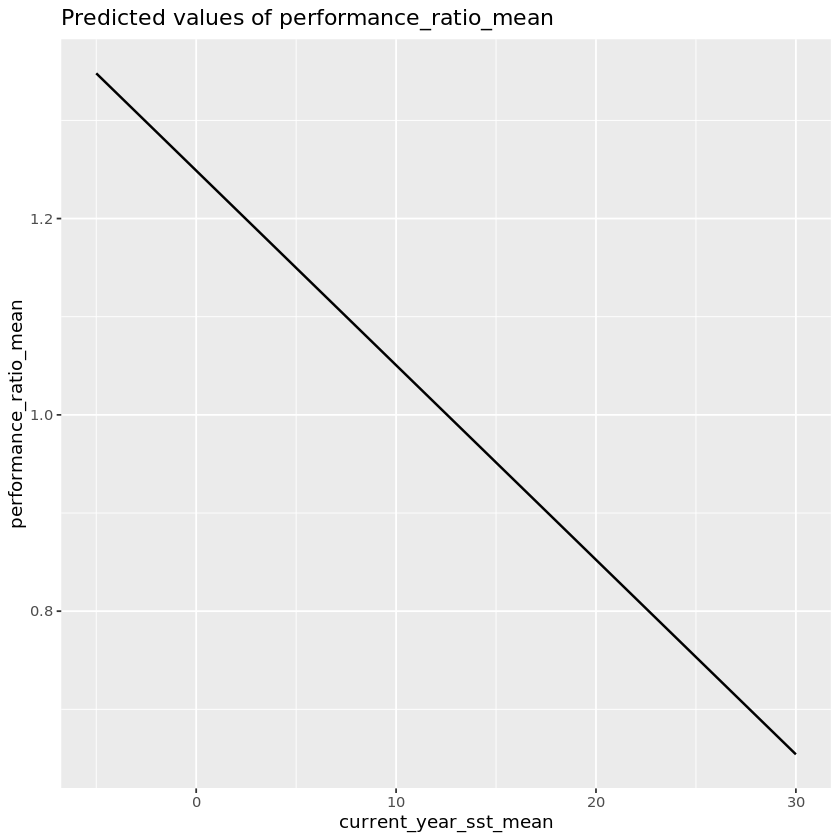

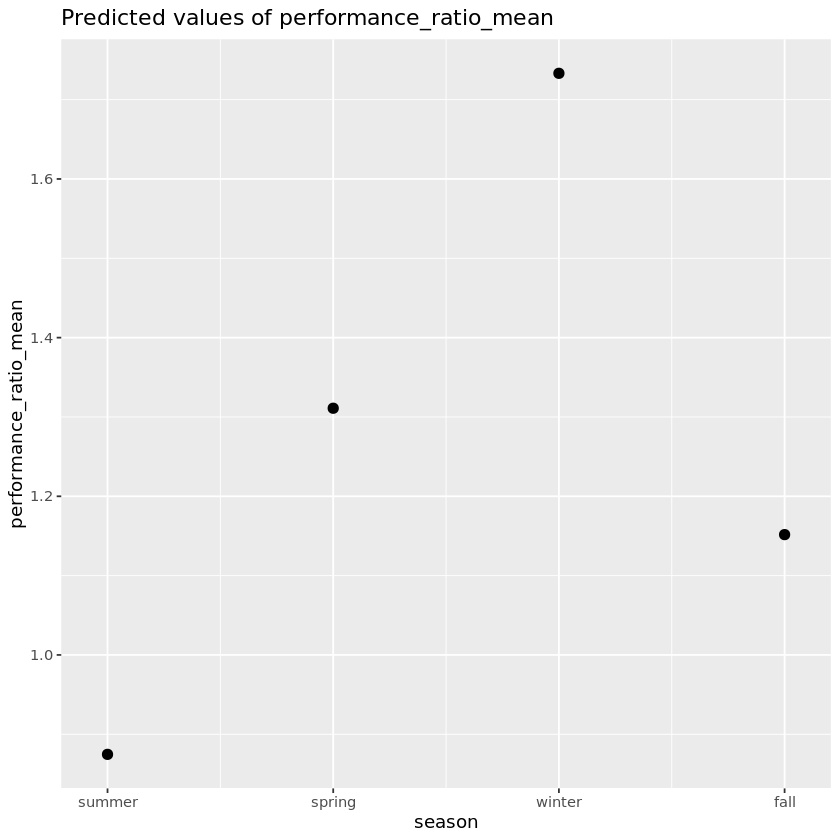

In [110]:
plot_model(simple_intense_re, type='pred')